In [417]:
import numpy as np
import pandas as pd
from keras import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.signal import argrelextrema
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split, KFold
from scipy.stats import uniform
import tensorflow as tf

In [418]:
# Load data and preprocess
# Read CSV and convert 'is_weekend' to integer values
data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)
df = pd.DataFrame(data)

In [419]:
# Select features and target
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend', 'engagement']
targets = ['engagement']
X = df[selected_features].values
y = df[targets].values

In [420]:
# Scale features and target
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
scaler_y = MinMaxScaler()
y_scaled = scaler_y.fit_transform(y)

In [421]:
# Create time series sequences
def create_sequences(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

# Set time steps and create sequences
time_steps = 10
X_seq, y_seq = create_sequences(X_scaled, y_scaled, time_steps)

In [422]:
train_size = 0.70 
val_size = 0.15  
test_size = 0.15  
X_train, X_temp, y_train, y_temp = train_test_split(X_seq, y_seq, train_size=train_size, random_state=42, shuffle=True)  
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=test_size / (val_size + test_size), random_state=42, shuffle=True)  

In [423]:
# Build LSTM model
def build_lstm_model(learning_rate=0.001, dropout_rate=0.4):
    model = Sequential()
    model.add(Input(shape=(time_steps, X_seq.shape[2])))  # Input layer
    model.add(LSTM(units=128, return_sequences=True))  # First LSTM layer
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(LSTM(units=64, return_sequences=False))  # Second LSTM layer
    model.add(BatchNormalization())  # Batch normalization layer
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(Dense(units=32, activation='relu'))  # Fully connected layer
    model.add(Dropout(dropout_rate))  # Dropout layer
    model.add(Dense(units=1))  # Output layer

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mse'])
    return model

In [424]:
# Simple hyperparameter tuning using a small grid search
learning_rate_values = [0.001, 0.01]
dropout_rate_values = [0.1, 0.2]

best_params = None
best_mse = float('inf')

total_combinations = len(learning_rate_values) * len(dropout_rate_values)
progress = 0

for learning_rate in learning_rate_values:
    for dropout_rate in dropout_rate_values:
        progress += 1
        print(f"Progress: {progress}/{total_combinations}, Learning Rate: {learning_rate}, Dropout Rate: {dropout_rate}")
        model = build_lstm_model(learning_rate=learning_rate, dropout_rate=dropout_rate)
        history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_val, y_val))
        val_loss, val_mse = model.evaluate(X_val, y_val, verbose=0)
        print(f"Validation Loss: {val_loss}, Validation MSE: {val_mse}")
        if val_mse < best_mse:
            best_mse = val_mse
            best_params = {'learning_rate': learning_rate, 'dropout_rate': dropout_rate}

print(f"Best Hyperparameters: {best_params}")

Progress: 1/4, Learning Rate: 0.001, Dropout Rate: 0.1
Validation Loss: 0.02468571811914444, Validation MSE: 0.02468571811914444
Progress: 2/4, Learning Rate: 0.001, Dropout Rate: 0.2
Validation Loss: 0.025048157200217247, Validation MSE: 0.025048157200217247
Progress: 3/4, Learning Rate: 0.01, Dropout Rate: 0.1
Validation Loss: 0.029766764491796494, Validation MSE: 0.029766764491796494
Progress: 4/4, Learning Rate: 0.01, Dropout Rate: 0.2
Validation Loss: 0.0453285314142704, Validation MSE: 0.0453285314142704
Best Hyperparameters: {'learning_rate': 0.001, 'dropout_rate': 0.1}


In [425]:
# Train the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
final_model = build_lstm_model(learning_rate=best_params['learning_rate'], dropout_rate=best_params['dropout_rate'])
history = final_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                          verbose=1, callbacks=[early_stopping])

Epoch 1/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.3704 - mse: 0.3704 - val_loss: 0.0752 - val_mse: 0.0752
Epoch 2/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.1040 - mse: 0.1040 - val_loss: 0.0723 - val_mse: 0.0723
Epoch 3/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0573 - val_mse: 0.0573
Epoch 4/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0572 - mse: 0.0572 - val_loss: 0.0490 - val_mse: 0.0490
Epoch 5/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0442 - mse: 0.0442 - val_loss: 0.0368 - val_mse: 0.0368
Epoch 6/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0276 - val_mse: 0.0276
Epoch 7/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0367 - mse: 0.0367 - val_loss: 0.0274 - val_mse: 0.0274
Epoch 8/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0355 - mse: 0.0355 - val_loss: 0.0248 - val_mse: 0.0248
Epoch 9/100
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.032

In [426]:
# Evaluate the model
loss, mse = final_model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {loss}")
print(f"Test MSE: {mse}")

Test Loss: 0.018526488915085793
Test MSE: 0.018526488915085793


In [427]:
# Predict and inverse scale predictions
y_pred = final_model.predict(X_test)
y_pred_rescaled = scaler_y.inverse_transform(y_pred)
y_test_rescaled = scaler_y.inverse_transform(y_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Predicted: [645967.2], Actual: [1292231.]
Predicted: [1390578.6], Actual: [892359.]
Predicted: [164743.95], Actual: [250986.]
Predicted: [64678.15], Actual: [3587.]
Predicted: [235820.61], Actual: [37359.]


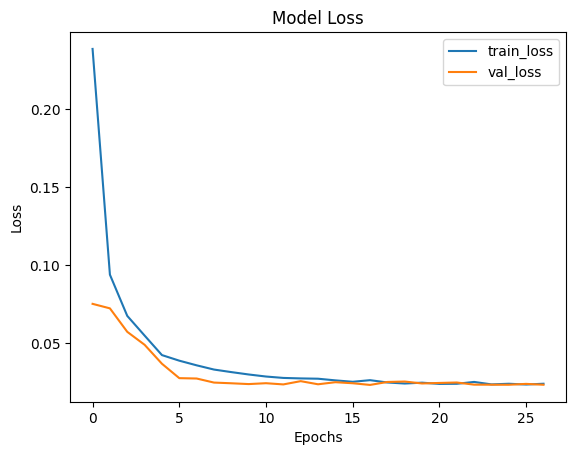

In [428]:
# Compare predictions and actual values
for i in range(5):
    print(f"Predicted: {y_pred_rescaled[i]}, Actual: {y_test_rescaled[i]}")

# Plot training and validation loss
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

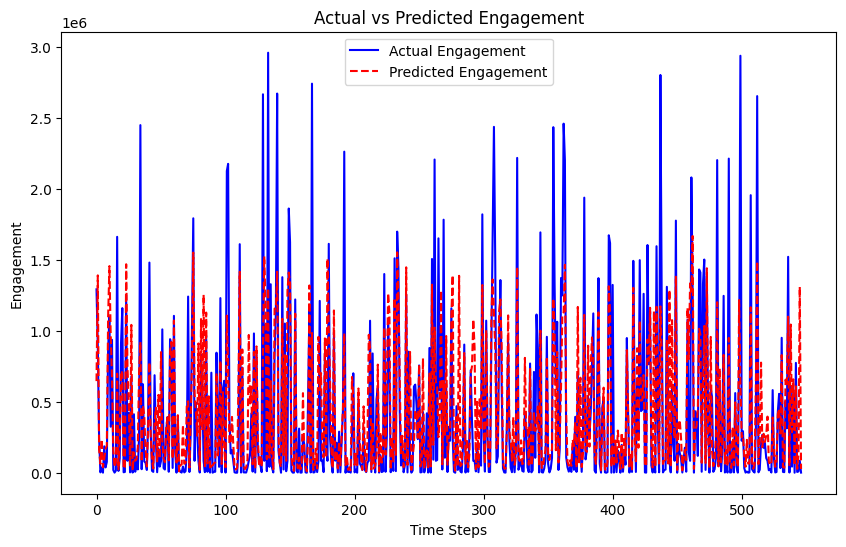

In [429]:
# Plot actual vs predicted engagement
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Engagement', color='b')
plt.plot(y_pred_rescaled, label='Predicted Engagement', color='r', linestyle='--')
plt.xlabel('Time Steps')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement')
plt.legend()
plt.show()

In [430]:
# Evaluate peaks using local maxima
true_local_max_indices = argrelextrema(y_test_rescaled.flatten(), comparator=np.greater)[0]
pred_local_max_indices = argrelextrema(y_pred_rescaled.flatten(), comparator=np.greater)[0]
y_test_peak_labels = np.zeros_like(y_test_rescaled.flatten(), dtype=int)
y_pred_peak_labels = np.zeros_like(y_pred_rescaled.flatten(), dtype=int)
y_test_peak_labels[true_local_max_indices] = 1
y_pred_peak_labels[pred_local_max_indices] = 1

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(y_test_peak_labels, y_pred_peak_labels)
precision = precision_score(y_test_peak_labels, y_pred_peak_labels)
recall = recall_score(y_test_peak_labels, y_pred_peak_labels)
f1 = f1_score(y_test_peak_labels, y_pred_peak_labels)
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.8720292504570384
Precision: 0.8089887640449438
Recall: 0.8
F1 Score: 0.8044692737430168


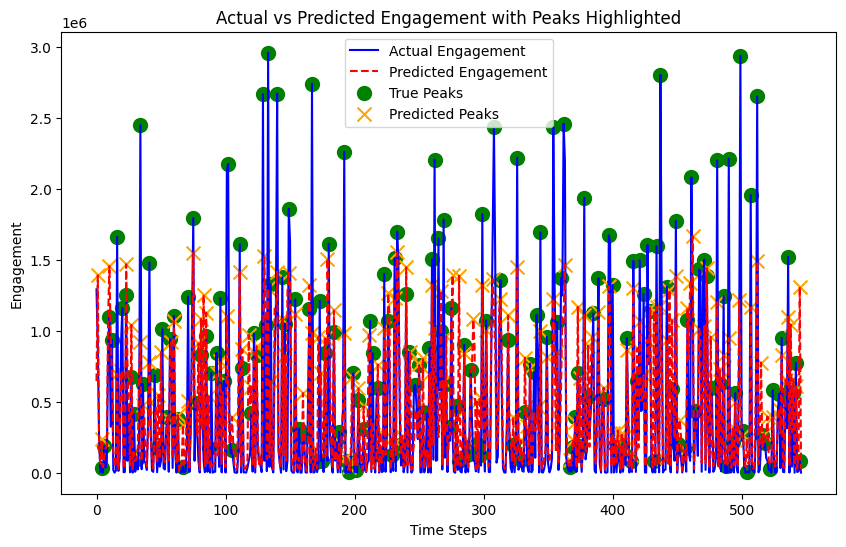

In [431]:
# Plot actual vs predicted engagement with peaks highlighted
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual Engagement', color='b')
plt.plot(y_pred_rescaled, label='Predicted Engagement', color='r', linestyle='--')
plt.scatter(true_local_max_indices, y_test_rescaled[true_local_max_indices], color='g', marker='o', s=100, label='True Peaks')
plt.scatter(pred_local_max_indices, y_pred_rescaled[pred_local_max_indices], color='orange', marker='x', s=100, label='Predicted Peaks')
plt.xlabel('Time Steps')
plt.ylabel('Engagement')
plt.title('Actual vs Predicted Engagement with Peaks Highlighted')
plt.legend()
plt.show()

Predicting 2023 Engagement: 100%|██████████| 365/365 [00:13<00:00, 26.66it/s]


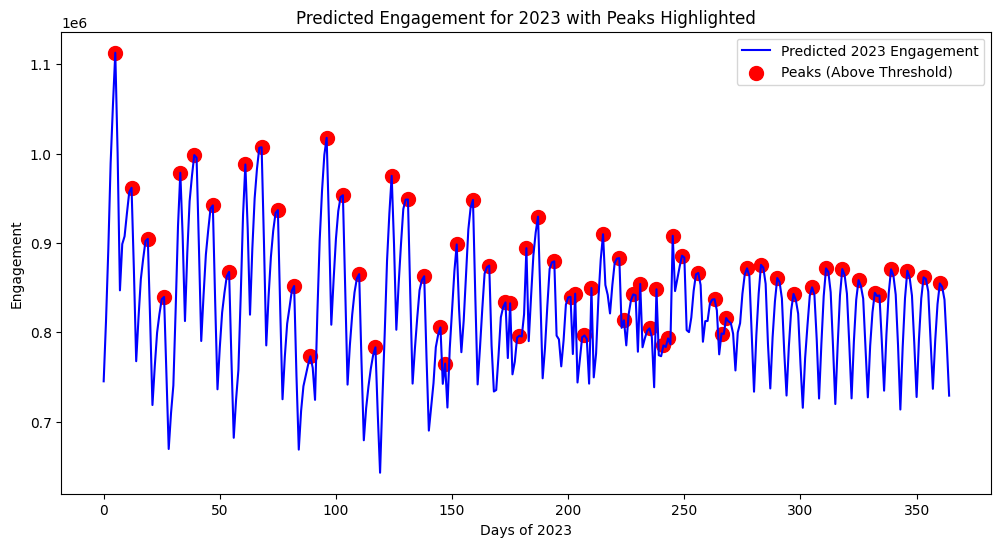

In [432]:
# Load and preprocess the data
# Read data from CSV and convert 'is_weekend' from string to integer

data = pd.read_csv('data_processed_filtered_outlier_imputed.csv')
data['is_weekend'] = data['is_weekend'].apply(lambda x: 1 if x == 'True' else 0)

# Select features and normalize
# Select relevant features and split them into time features and target feature
selected_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend', 'engagement']
time_features = ['tweet_year', 'tweet_month', 'tweet_days', 'tweet_day', 'is_weekend']
engagement_feature = ['engagement']

# Normalize time features and engagement separately
scaler_time = MinMaxScaler()
scaler_time.fit(data[time_features])

scaler_engagement = MinMaxScaler()
scaler_engagement.fit(data[engagement_feature])

# Prepare input data for prediction
# Extract the last time_steps data from 2022 as the starting input sequence
data_2022 = data[data['tweet_year'] == 2022]
last_sequence = data_2022[selected_features].values[-10:]

# Normalize the initial sequence
# Scale time features and engagement separately, then concatenate them
time_sequence_scaled = scaler_time.transform(pd.DataFrame(last_sequence[:, :-1], columns=time_features))
engagement_sequence_scaled = scaler_engagement.transform(pd.DataFrame(last_sequence[:, -1].reshape(-1, 1), columns=engagement_feature))

# Combine time features and engagement features
last_sequence_scaled = np.hstack((time_sequence_scaled, engagement_sequence_scaled))

# Predict engagement for each day of 2023
# Initialize an empty list to store predicted engagement values for 2023
predicted_2023 = []
current_sequence = last_sequence_scaled

# Start date for 2023 prediction
last_date = pd.to_datetime(f"{int(data_2022.iloc[-1]['tweet_year'])}-{int(data_2022.iloc[-1]['tweet_month'])}-{int(data_2022.iloc[-1]['tweet_days'])}")

# Predict for 365 days in 2023
for i in tqdm(range(365), desc="Predicting 2023 Engagement", leave=True):
    # Calculate the current date
    current_date = last_date + timedelta(days=i + 1)

    # Compute time features for the current date
    tweet_year = current_date.year
    tweet_month = current_date.month
    tweet_days = current_date.day
    tweet_day = current_date.weekday()
    is_weekend = 1 if tweet_day in [5, 6] else 0

    # Create an array of new time features
    new_time_features = pd.DataFrame([[tweet_year, tweet_month, tweet_days, tweet_day, is_weekend]], columns=time_features)
    new_time_features_scaled = scaler_time.transform(new_time_features)  # Normalize the new time features

    # Extract engagement from the last time step
    engagement_features = pd.DataFrame(current_sequence[-1:, -1].reshape(-1, 1), columns=engagement_feature)

    # Create new input by combining new time features and historical engagement
    new_input = np.hstack((new_time_features_scaled, engagement_features))

    # Update the input sequence to create a rolling window for LSTM prediction
    current_sequence = np.vstack([current_sequence[1:], new_input])
    current_sequence_expanded = np.expand_dims(current_sequence, axis=0)

    # Predict the next day's engagement using the trained LSTM model
    predicted_value_scaled = final_model.predict(current_sequence_expanded, verbose=0)
    predicted_value = scaler_engagement.inverse_transform(predicted_value_scaled)  # Inverse normalization
    predicted_2023.append(predicted_value[0, 0])

# Find and visualize peaks in the 2023 predictions
# Convert predicted values to a NumPy array
predicted_2023 = np.array(predicted_2023)

# Identify local maxima (peaks) using scipy's argrelextrema function
threshold = 0
local_max_indices = argrelextrema(predicted_2023, comparator=np.greater)[0]

# Select peaks that are above the specified threshold
peak_indices = [idx for idx in local_max_indices if predicted_2023[idx] > threshold]

# Plot the predicted engagement for 2023 with peaks highlighted
plt.figure(figsize=(12, 6))
plt.plot(predicted_2023, label='Predicted 2023 Engagement', color='b')
plt.scatter(peak_indices, predicted_2023[peak_indices], color='r', marker='o', s=100, label='Peaks (Above Threshold)')
plt.xlabel('Days of 2023')
plt.ylabel('Engagement')
plt.title('Predicted Engagement for 2023 with Peaks Highlighted')
plt.legend()
plt.show()